# Building a Spam Filter with Naive Bayes

<p style='font-size:17px'>In this project I will focus on creating a spam message filter with the help of multinomial Naive Bayes algorithm</p>

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spam = pd.read_csv('SMSSpamCollection',sep='\t',header=None,names=['Label', 'SMS'])

In [4]:
spam.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
spam.shape

(5572, 2)

In [7]:
spam['Label'].value_counts(normalize=True) * 100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

So the 'ham' label here denotes non-spam messages which constitutes around 86.5% of the dataset

(0, 100)

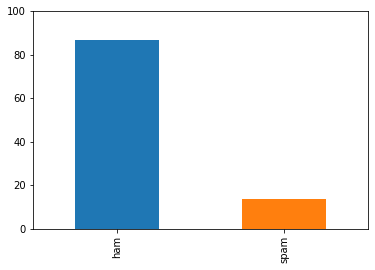

In [21]:
(spam['Label'].value_counts(normalize=True) * 100).plot.bar()
plt.ylim(0,100)

## Splitting data into train and test

We will split the whole dataset into 80% training and 20% testing

In [22]:
#randomizing the data
randomized_data = spam.sample(frac=1,random_state = 1)

In [23]:
#getting the index to split from
index = round(len(randomized_data) * 0.8)

In [26]:
#splitting the  data
train = randomized_data[:index].reset_index(drop=True)
test = randomized_data[index:].reset_index(drop=True)

print(train.shape)
print(test.shape)

(4458, 2)
(1114, 2)


Now that I have succesfully split the data let's see the representativity of each split to the actual dataset

In [27]:
train['Label'].value_counts(normalize=True) * 100

ham     86.54105
spam    13.45895
Name: Label, dtype: float64

In [28]:
test['Label'].value_counts(normalize=True) * 100

ham     86.804309
spam    13.195691
Name: Label, dtype: float64

We see that the percentages of spam and ham in the samples is very representative to the dataset

## Data Cleaning and Formatting

In [29]:
#removing punctuation and changing to lower case
train['SMS'] = train['SMS'].str.replace('\W',' ')
train['SMS'] = train['SMS'].str.lower()

In [30]:
train.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


In [31]:
#splitting each unique word
train['SMS'] = train['SMS'].str.split()

In [32]:
train.head()

,Label,SMS
0,ham,"[yep, by, the, pretty, sculpture]"
1,ham,"[yes, princess, are, you, going, to, make, me,..."
2,ham,"[welp, apparently, he, retired]"
3,ham,[havent]
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,..."


In [33]:
#creating a vocabulary of all the unique words
vocabulary = []

for sms in train['SMS']:
    for word in  sms:
        if word not in vocabulary:
            vocabulary.append(word)
        
len(vocabulary)

7783

In [34]:
word_count_per_sms = {}

for word in vocabulary:
    word_count_per_sms[word] = [0] * len(train['SMS'])

In [37]:
for index, sms in enumerate(train['SMS']):
    for word in sms:
        word_count_per_sms[word][index] += 1

In [38]:
word_counts = pd.DataFrame(word_count_per_sms)
word_counts.head()

,yep,by,the,pretty,sculpture,yes,princess,are,you,going,...,beauty,hides,secrets,n8,jewelry,related,trade,arul,bx526,wherre
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
train_clean = pd.concat([train,word_counts],axis=1)
train_clean.head()

,Label,SMS,yep,by,the,pretty,sculpture,yes,princess,are,...,beauty,hides,secrets,n8,jewelry,related,trade,arul,bx526,wherre
0,ham,"[yep, by, the, pretty, sculpture]",1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
train_clean['Label'].shape[0]

4458

In [46]:
p_spam = train_clean['Label'].value_counts()['spam'] / train_clean['Label'].shape[0]
p_ham = train_clean['Label'].value_counts()['ham'] / train_clean['Label'].shape[0]

In [47]:
spam_label = train_clean[train_clean['Label']=='spam']
ham_label = train_clean[train_clean['Label']=='ham']

In [49]:
# N_Spam
n_words_per_spam_message = spam_label['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_label['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

# Parameter Calculation

In [51]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_label[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_label[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

# Classifying new message

In [52]:
import re

def classify(message):
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
            
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [53]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [54]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


# Measuring Spam Filter's Accuracy

In [55]:
def classify_test_set(message):    
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
    
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [56]:
test['predicted'] = test['SMS'].apply(classify_test_set)
test.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [58]:
correct = 0
total = test.shape[0]
    
for row in test.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1
        
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833
